In [9]:
%run model.py

In [10]:
import sys
sys.path.insert(1, '../src/')
from scot import *

In [11]:
X=np.genfromtxt("../data/scGEM_expression.csv", delimiter=",")
y=np.genfromtxt("../data/scGEM_methylation.csv", delimiter=",")
print("Dimensions of input datasets are: ", "X= ", X.shape, " y= ", y.shape)

Dimensions of input datasets are:  X=  (177, 34)  y=  (177, 27)


model start
2


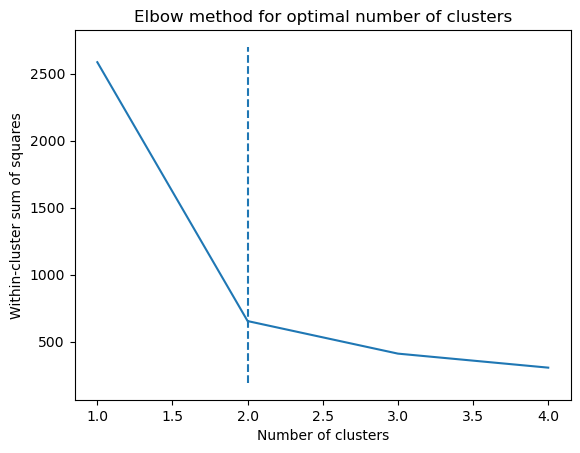

Best number of clusters: 2


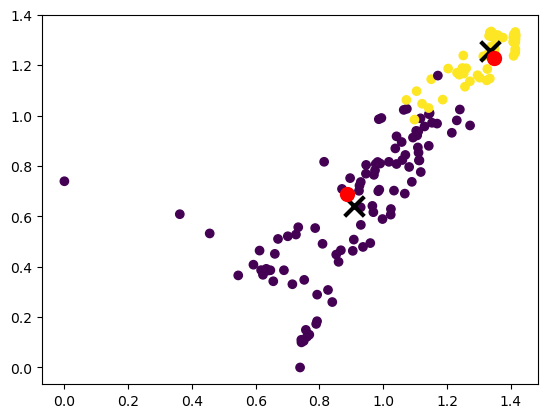

2


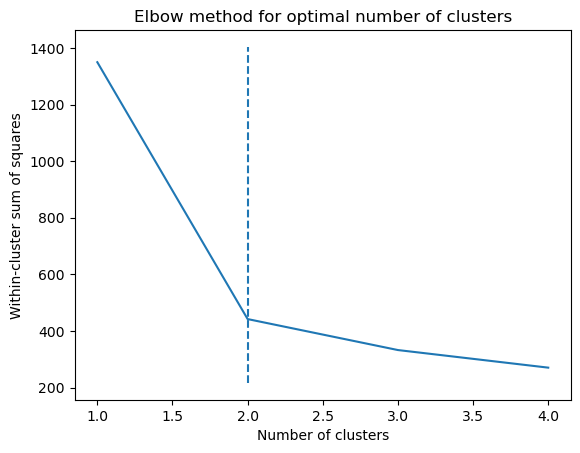

Best number of clusters: 2


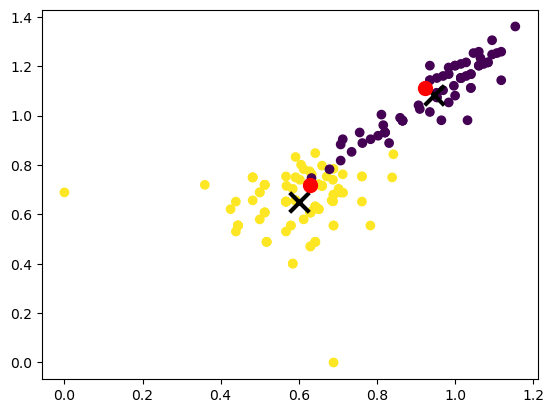

iter 0
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
iter 1
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
iter 2
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
iter 3
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
iter 4
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
It.  |Err         
-------------------
    0|5.649717e-03|
model takes 2.324805 seconds


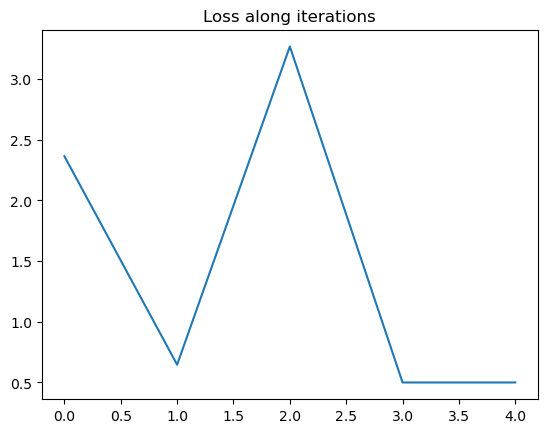

In [12]:
C1, C2, C1_opt, C2_opt = model(X,y, epsilon=1e-20, tol = 1e-2, lr=10)

In [13]:
C1_opt.shape

(177, 177)

In [14]:
p = ot.unif(C1.shape[0])
q = ot.unif(C2.shape[0])
distance_C1_C2 = ot.gromov.entropic_gromov_wasserstein2(C1, C2, p, q, loss_fun = 'square_loss', epsilon=1e-2)
print('distance between C1 and C2:', distance_C1_C2)

distance between C1 and C2: 0.049450382157990636


In [16]:
p = ot.unif(C1_opt.shape[0])
q = ot.unif(C2_opt.shape[0])
distance_C1_opt_C2_opt = ot.gromov.entropic_gromov_wasserstein2(C1_opt, C2_opt, p, q, loss_fun = 'square_loss', epsilon=1e-10)
print('distance between C1_opt and C2_opt:', distance_C1_opt_C2_opt)

distance between C1_opt and C2_opt: 0.0


In [ ]:
p = ot.unif(C1_opt.shape[0])
q =  ot.unif(C2_opt.shape[0])
P = ot.gromov.entropic_gromov_wasserstein(C1_opt, C2_opt, p, q, loss_fun='square_loss', epsilon = 1e-1, log=False, verbose=True)

In [ ]:
C1

In [ ]:
C2

In [ ]:
C1_opt

In [ ]:
C2_opt

In [ ]:
def is_distance_matrix(matrix):
    """
    Checks whether a given matrix is a distance matrix or not.
    """
    n = len(matrix)
    
    # Check condition 1
    for i in range(n):
        if matrix[i][i] != 0:
            return False
    
    # Check condition 2
    for i in range(n):
        for j in range(n):
            if matrix[i][j] != matrix[j][i]:
                return False
    
    # Check condition 3
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if matrix[i][j] > matrix[i][k] + matrix[k][j]:
                    return False
    
    return True


In [ ]:
is_distance_matrix(C1_opt)

In [ ]:
P.shape

In [ ]:
# projection
#Projecting the first domain onto the second domain
y_new=normalize(y)
print(y_new.shape)
weights=np.sum(P,axis = 0)
print(weights.shape)
print(np.matmul(P, normalize(y)).shape)
X_new =np.matmul(P, y_new) / weights[:, None]
print(X_new.shape)

In [ ]:
y_new.shape

In [ ]:
X_new.shape

In [ ]:
import evals 

# We will use the average FOSCTTM measure implemented in evals.py for evaluation (metric used in the publication Demetci et al 2021)
# This measure reports the fraction of samples closer to a sample than its true match (FOSCTTM), averaged over all samples. 
fracs=evals.calc_domainAveraged_FOSCTTM(X_new, y_new)
print("Average FOSCTTM score for this alignment with X onto Y is: ", np.mean(fracs))

In [ ]:
import matplotlib.pyplot as plt
legend_label="SCOT alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "r--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Reduce the dimensionality of the aligned domains to two (2D) via PCA for the sake of visualization:

pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((X_new, y_new), axis=0))
X_pca=Xy_pca[0: 177,]
y_pca=Xy_pca[177:,]


#Plot aligned domains, samples colored by domain identity:
plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=15, label="Gene Expression")
plt.scatter(y_pca[:,0], y_pca[:,1], c="r", s=15, label="DNA Methylation")
plt.legend()
plt.title("Colored based on domains (Aligned Domains)")
plt.show()

In [ ]:
#Plot aligned domains, samples colored by cell types:
cellTypes_rna=np.loadtxt("../data/scGEM_typeExpression.txt")
cellTypes_methyl=np.loadtxt("../data/scGEM_typeMethylation.txt")

colormap = plt.get_cmap('rainbow', 5) 
plt.scatter(X_pca[:,0], X_pca[:,1], c=cellTypes_rna, s=15, cmap=colormap)
plt.scatter(y_pca[:,0], y_pca[:,1], c=cellTypes_methyl, s=15, cmap=colormap)
cbar=plt.colorbar()

# approximately center the colors on the colorbar when adding cell type labels
tick_locs = (np.arange(1,6)+0.8) *4/5 
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(["BJ", "d8", "d16T+", "d24T+", "iPS"]) #cell-type labels
plt.title("Colored based on cell type identity")
plt.show()


In [ ]:
originalX_pca=pca.fit_transform(normalize(X))
originaly_pca=pca.fit_transform(normalize(y))

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c="k", s=15)
ax1.set_title("DNA Methylation Domain \n *before* Alignment")
ax2.scatter(originaly_pca[:,0], originaly_pca[:,1], c="r", s=15)
ax2.set_title("Gene Expression Domain \n *before* Alignment")

In [ ]:
#Visualization of the cell type clusters in original domains *before* alignment
fig, (ax1, ax2)= plt.subplots(1,2)

fig1= ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c=cellTypes_rna, s=15, cmap=colormap)
ax1.set_title("DNA Methylation \n *before* Alignment")

fig2= ax2.scatter(originaly_pca[:,0], originaly_pca[:,1],  c=cellTypes_methyl, s=15, cmap=colormap)
ax2.set_title("Gene Expression Domain \n *before* Alignment")

cbar=fig.colorbar(fig2)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(["BJ", "d8", "d16T+", "d24T+", "iPS"]) #cell-type labels